# Crowd for Good - Breast Cancer Prediction Match

## Project Background
Topcoder has started on an important Philanthropic journey, where we will explore ways to use Software and Data Science tools to build useful solutions in the area of Cancer and Oncology.

The objective of the project is to leverage Topcoder member software development skills and Data Science skills in order to make progress in the field of Oncology.

This progress can be in any sub-area, but it's mostly going to revolve around the sub-area of Cancer Prevention.

Note: Overall project is highly interactive and we are building this challenge and planning future ones relying on members inputs and suggestions.

## Challenge Details
Explore the risk factors and their combinations to predict the risk of breast cancer. We would like to see the most accurate risk factor analysis through this challenge outcome.

- The provided dataset includes participant characteristics previously shown to be associated with breast cancer risk estimation including age, race/ethnicity, age at first birth, breast density, mammogram result, use of hormone replacement therapy, menopausal status, surgical menopause, body mass index, breast procedure, and diagnosis of invasive breast cancer.
- These data can be used to describe the distribution of breast cancer risk in the general population or to explore relationships among breast cancer risk factors.
- You need to prepare and train a model using the provided training dataset. This should predict the breast cancer result for the input testing dataset.

## DATASET DETAILS
In this challenge, you will work with a csv file that contains a risk estimation dataset for breast cancer. The data dictionary is also provided for the format of the dataset used in this challenge. The original dataset is partitioned into training, provisional and final testing datasets, in which the training dataset contains the column “cancer” indicating the actual breast cancer result (0 = no & 1 = yes).

Note: "Data collection and sharing was supported by the National Cancer Institute-funded Breast Cancer Surveillance Consortium (HHSN261201100031C). You can learn more about the BCSC at: http://www.bcsc-research.org/. Data for this study was obtained from the BCSC: http://bcsc-research.org/."

RESOURCES
All required files for this challenge can be downloaded from the shared location [here](https://drive.google.com/drive/folders/12WAHaOzaHjsyuFQxcwaR1prxSLCXSIHZ). Please find the details below:

data-training.zip: The full training dataset which must be used to train the model.

data-provisional.zip: The provisional testing dataset. Your submissions must contain prediction data from this dataset.

sample-submission.zip: A sample submission package to illustrate the required submission format.

Data Dictionary: It contains the descriptions of the format and content of the training data. It can be accessed online [here](https://docs.google.com/spreadsheets/d/1wPk9xs419vgKuotFq32Oi6SNWDWBZVyZP9IpZBf7ImY).

Data Stratification: The original dataset is partitioned into training, provisional and final testing datasets by randomly considering id column as row identifier.

## SOLUTION REQUIREMENTS
- Your solution can be in C/C++, Python or any programming language.
- The project submission shall include a description and theory behind any preprocessing algorithm used to transform the ‘raw’ data before it is used by the correlation algorithms.
- Solution output must be a csv file having two columns as:
    - id: The identifier column value must match the corresponding row in the input testing file.
    - prediction: The predicted data for the breast cancer probability values as float numbers within range [0,1].

## SUBMISSION FORMAT
The required format of the submission package is specified in a submission template document. This current document gives only requirements that are either additional or override the requirements listed in the template.

- Submit your source code as a zip file for final scoring and a solution file for provisional scoring. Please refer sample-submission.zip file for the expected folder structure and required files for the submission scoring.
- The output of your algorithm should be a single csv file that lists the prediction result for each row in the input dataset.
- Please update Dockerfile for the prerequisite software stack used in the solution and the README file as appropriate, explaining changes to folder structure, updated software stack and relevant packages and versions, as well as instructions on how to run your algorithm. Please also include any references used in your README file.
- Winners may be asked to submit a separate whitepaper.
- Your output must only contain algorithmically generated detections. It is strictly forbidden to include hand labeled data, or data that - although initially machine generated - is modified in any way by a human.

## SCORING DETAILS
During scoring, your output files (as contained in your submission file during provisional testing, or generated by your docker container during final testing) will be matched against the expected ground truth data using the following method.

- If your solution is invalid (e.g. if the tester tool can't successfully parse its content or if it violates the constraints listed in the Output File section), you will receive a score of -1.
- We are going to mainly evaluate your method based on the AUC score. We would like to see a model achieving a great balanced score.

In [3]:
# importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
import pycaret
from pycaret.classification import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [11]:
# loading and analysing data
TRAIN_DATA = "data/training.csv"
TEST_DATA = "data/testing.csv"

DATA_DICT = "data/data_dictionary.csv"
df_dict = pd.read_csv(DATA_DICT,index_col=None)

df_train = pd.read_csv(TRAIN_DATA)
df_test = pd.read_csv(TEST_DATA)
print(f'Train Data Length : {df_train.__len__()}')
print(f'Test Data Length : {df_test.__len__()}')
df_train.head()

Train Data Length : 196462
Test Data Length : 28066


,id,menopaus,agegrp,density,race,Hispanic,bmi,agefirst,nrelbc,brstproc,lastmamm,surgmeno,hrt,invasive,cancer,count
0,RE-TRAIN-0000001,0,1,1,1,0,1,0,0,0,9,9,9,0,0,2
1,RE-TRAIN-0000002,0,1,1,1,0,1,0,0,0,9,9,9,0,0,4
2,RE-TRAIN-0000003,0,1,1,1,0,1,0,1,0,0,9,9,0,0,1
3,RE-TRAIN-0000004,0,1,1,1,0,1,0,1,0,9,9,9,0,0,1
4,RE-TRAIN-0000005,0,1,1,1,0,1,1,0,0,0,9,9,0,0,2


In [12]:
df_test.head()

,id,menopaus,agegrp,density,race,Hispanic,bmi,agefirst,nrelbc,brstproc,lastmamm,surgmeno,hrt,invasive,count
0,RE-PROV-0000001,0,1,1,1,0,1,0,0,0,0,9,9,0,4
1,RE-PROV-0000002,0,1,1,1,0,2,0,1,0,9,9,9,0,1
2,RE-PROV-0000003,0,1,1,1,0,2,9,0,0,0,9,9,0,4
3,RE-PROV-0000004,0,1,1,1,0,2,9,1,0,0,9,9,0,2
4,RE-PROV-0000005,0,1,1,1,0,3,2,0,0,9,9,9,0,3


In [9]:
# data dictionary
"""The provided dataset includes participant characteristics previously shown 
to be associated with breast cancer risk estimation including age, race/ethnicity, 
age at first birth, breast density, mammogram result, use of hormone replacement 
therapy, menopausal status, surgical menopause, body mass index, breast procedure,
and diagnosis of invasive breast cancer.
"""
df_dict.style.hide_index()

Column,Column Name,Column Data
0,id,Identifier of the row
1,menopaus,0 = premenopausal; 1 = postmenopausal or age>=55 ; 9 = unknown
2,agegrp,1 = 35-39; 2 = 40-44; 3 = 45-49; 4 = 50-54; 5 = 55-59; 6 = 60-64; 7 = 65-69; 8 = 70-74; 9 = 75-79; 10 = 80-84
3,density,BI-RADS breast density codes 1 = Almost entirely fat; 2 = Scattered fibroglandular densities; 3 = Heterogeneously dense; 4 = Extremely dense; 9 = Unknown or different measurement system
4,race,1 = white; 2 = Asian/Pacific Islander; 3 = black; 4 = Native American; 5 = other/mixed; 9 = unknown
5,Hispanic,0 = no; 1 = yes; 9 = unknown
6,bmi,Body mass index: 1 = 10-24.99; 2 = 25-29.99; 3 = 30-34.99; 4 = 35 or more; 9 = unknown
7,agefirst,Age at first birth: 0 = Age < 30; 1 = Age 30 or greater; 2 = Nulliparous; 9 = unknown
8,nrelbc,Number of first degree relatives with breast cancer: 0 = zero; 1= one; 2 = 2 or more; 9 = unknown
9,brstproc,Previous breast procedure: 0 = no; 1 = yes; 9 = unknown


In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196462 entries, 0 to 196461
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        196462 non-null  object
 1   menopaus  196462 non-null  int64 
 2   agegrp    196462 non-null  int64 
 3   density   196462 non-null  int64 
 4   race      196462 non-null  int64 
 5   Hispanic  196462 non-null  int64 
 6   bmi       196462 non-null  int64 
 7   agefirst  196462 non-null  int64 
 8   nrelbc    196462 non-null  int64 
 9   brstproc  196462 non-null  int64 
 10  lastmamm  196462 non-null  int64 
 11  surgmeno  196462 non-null  int64 
 12  hrt       196462 non-null  int64 
 13  invasive  196462 non-null  int64 
 14  cancer    196462 non-null  int64 
 15  count     196462 non-null  int64 
dtypes: int64(15), object(1)
memory usage: 24.0+ MB


In [13]:
df_train.describe()

,menopaus,agegrp,density,race,Hispanic,bmi,agefirst,nrelbc,brstproc,lastmamm,surgmeno,hrt,invasive,cancer,count
count,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000,196462.000000
mean,1.308752,5.469674,4.093718,3.171438,2.887917,4.775483,3.372927,1.571271,1.450362,3.042176,4.118303,3.316484,0.025608,0.033187,8.474825
std,1.908668,2.387198,2.958682,3.145186,4.062008,3.469497,3.973707,3.057983,2.940595,4.198951,4.272907,4.050667,0.157963,0.179125,54.367564
min,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,4.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,5.000000,3.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,7.000000,9.000000,4.000000,9.000000,9.000000,9.000000,1.000000,1.000000,9.000000,9.000000,9.000000,0.000000,0.000000,4.000000
max,9.000000,10.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,1.000000,7295.000000


<AxesSubplot:>

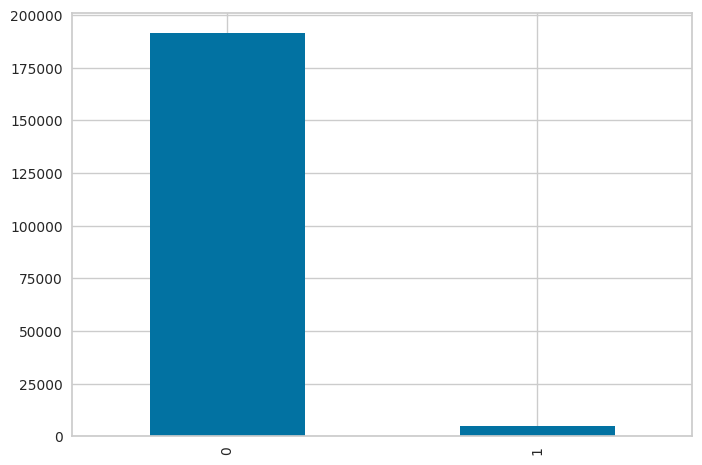

In [29]:
df_train.cancer.value_counts().plot.bar()
# It shows that the dataset is highly imbalanced.

## Exploratory Data Analysis

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


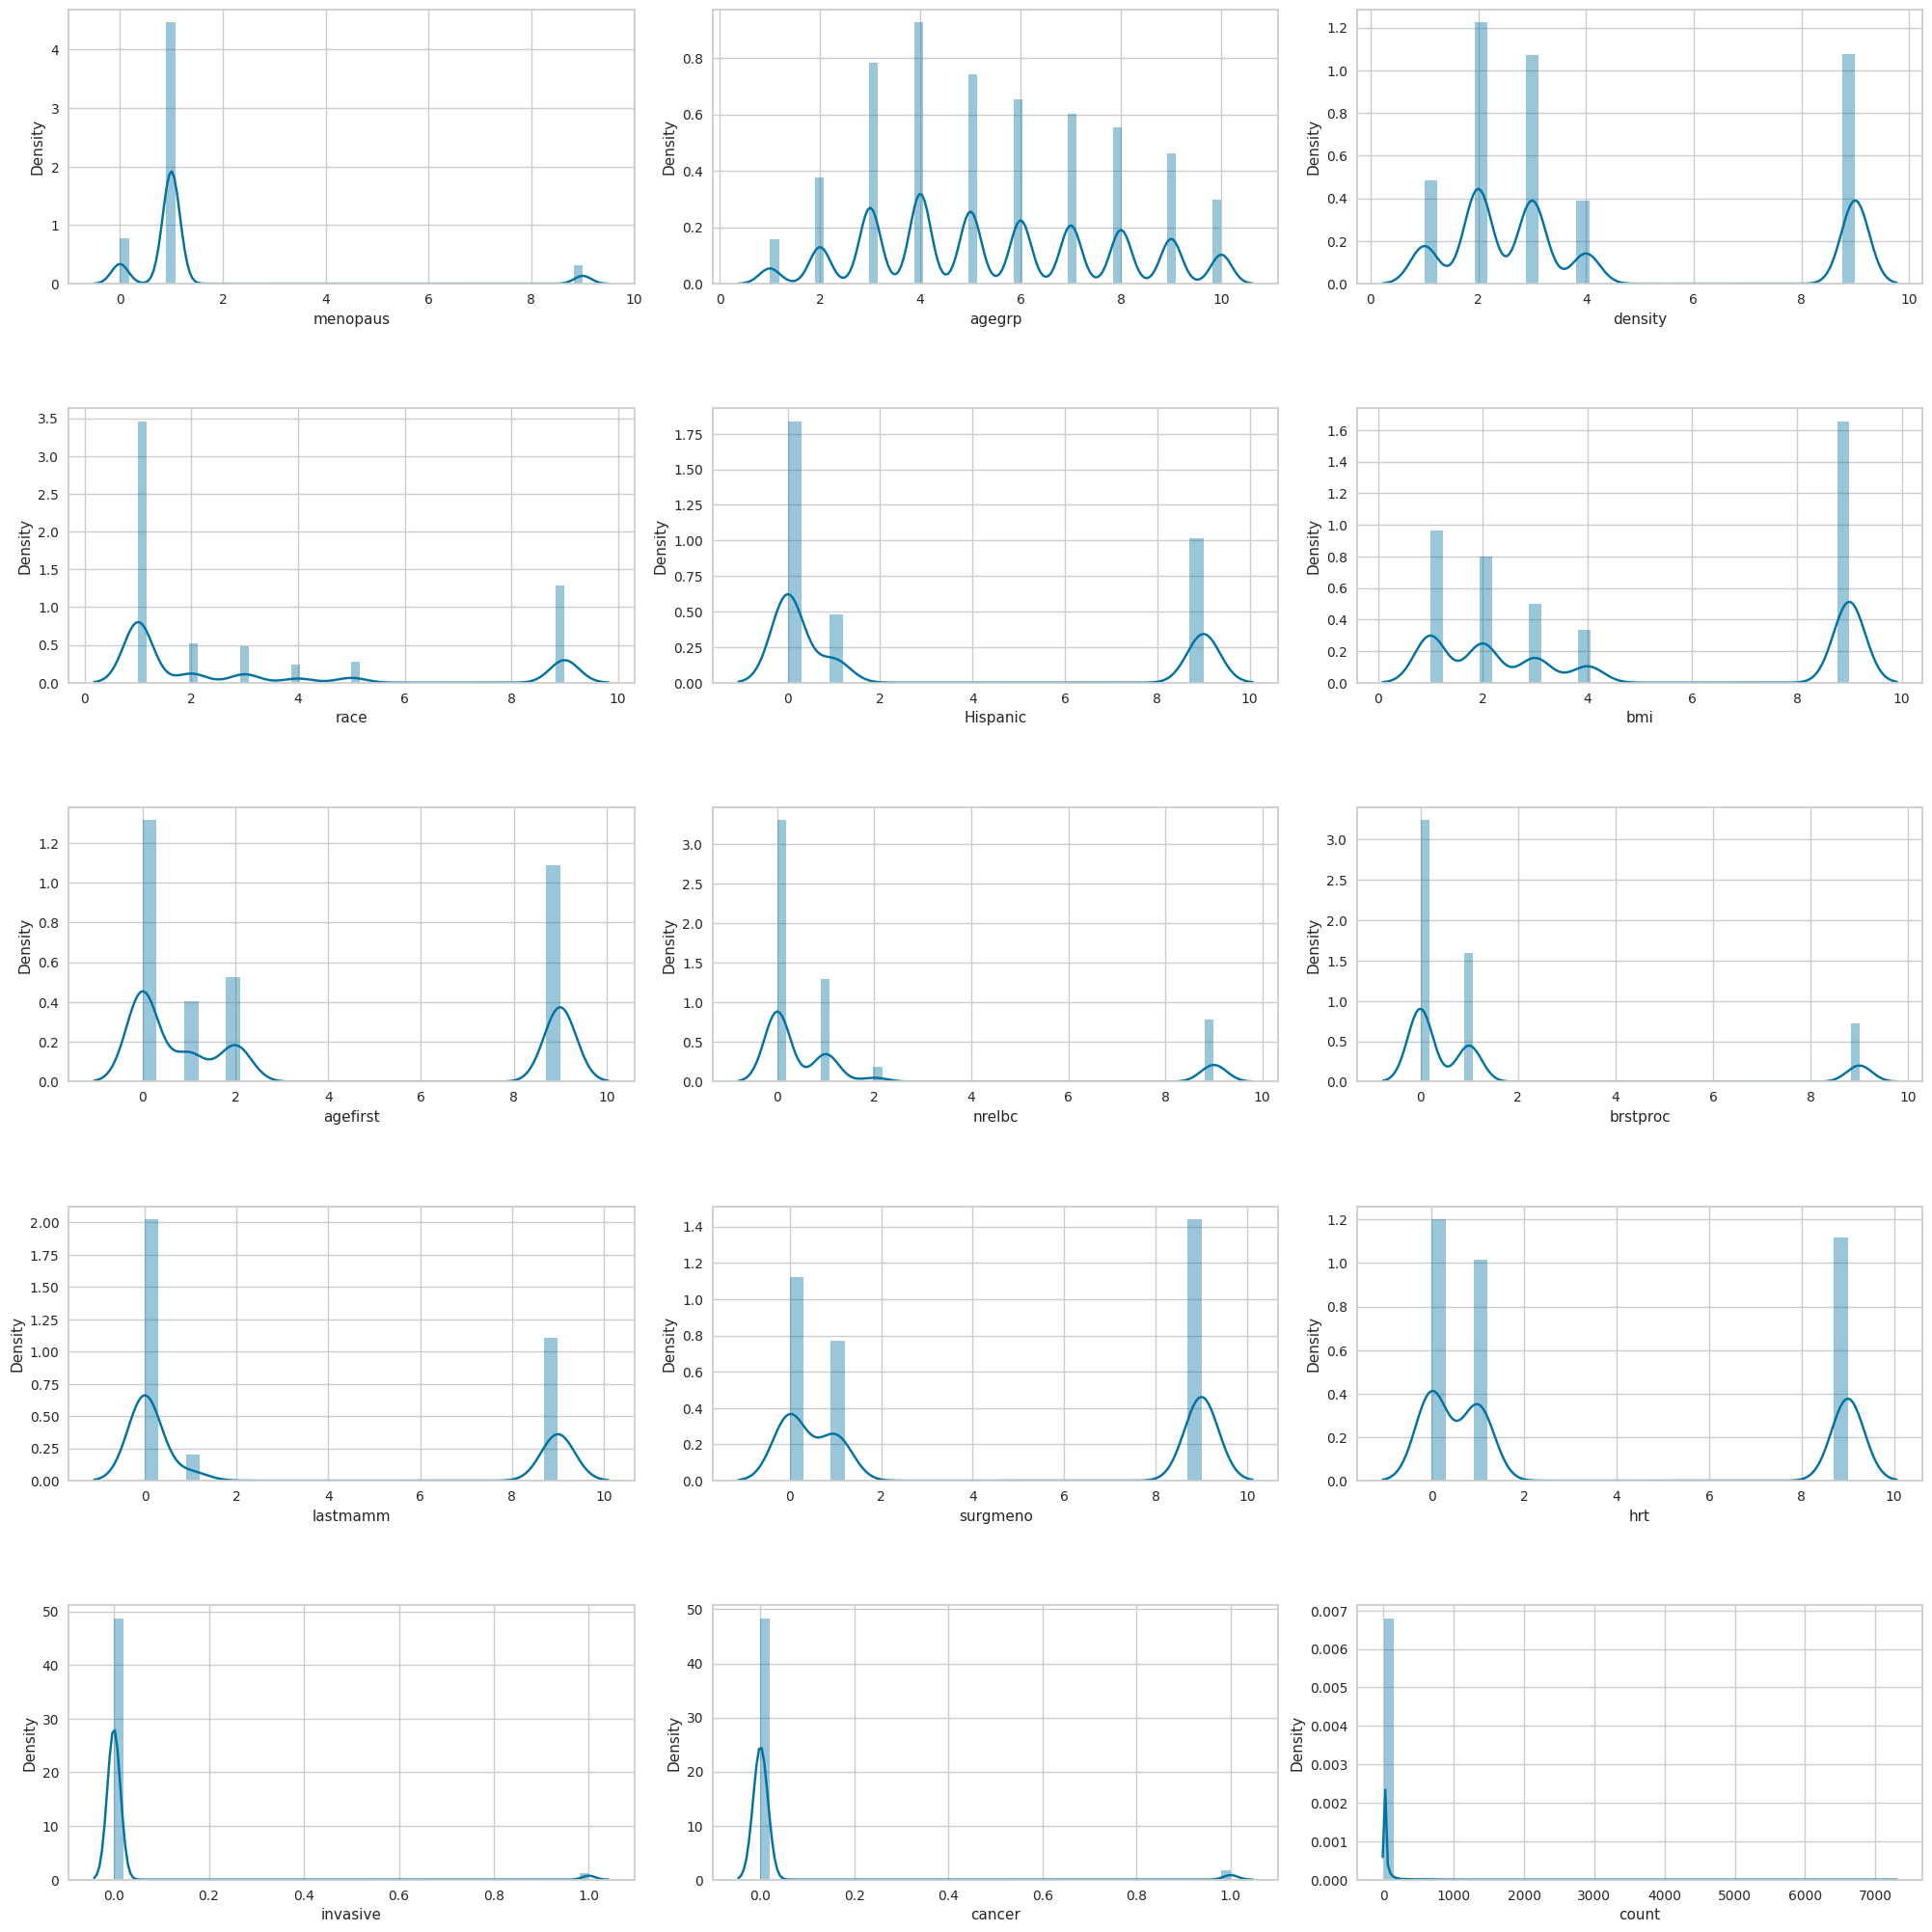

In [15]:
# create dist plot
fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(20, 20))
ax = ax.flatten()
Z = df_train.drop(columns=['id'], axis=1)
for index,col in enumerate(Z.columns):
    sns.distplot(df_train[col], ax=ax[index])
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

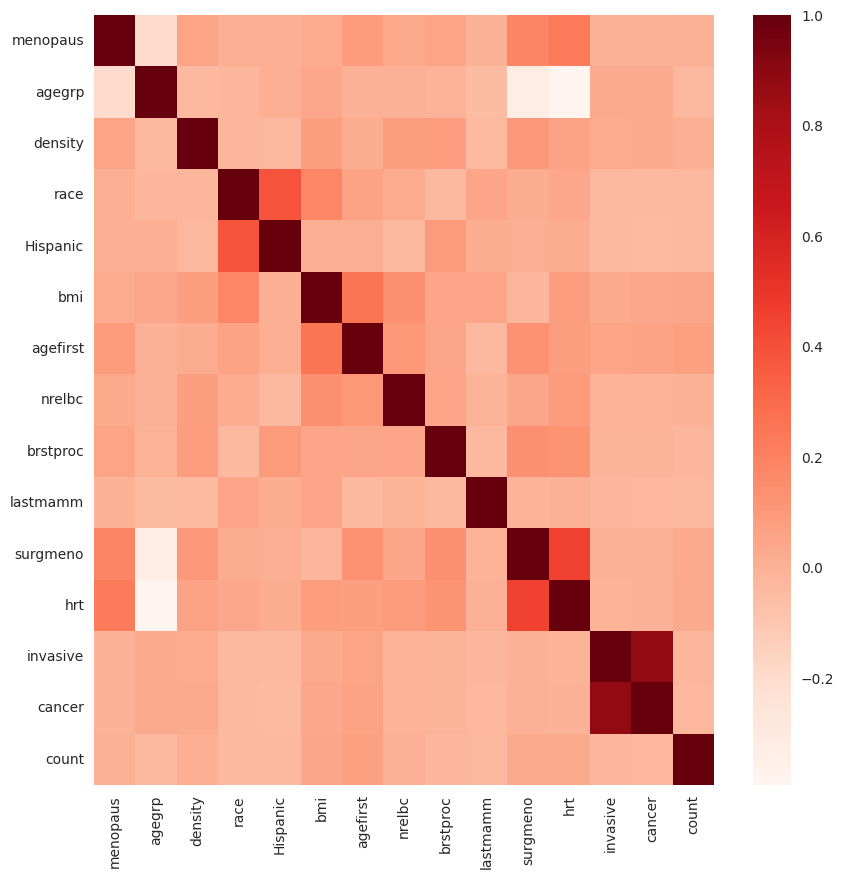

In [28]:
corr = df_train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="Reds")
plt.show()

In [39]:
# data splitting
from sklearn.model_selection import train_test_split
X = df_train.drop(columns=['id','invasive','cancer'], axis=1)
y = df_train['cancer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
#using pycaret
data = df_train.drop(['id'],axis=1)
# init setup
from pycaret.classification import *
s = setup(data = data, target = 'cancer', session_id=123)

,Description,Value
0,session_id,123
1,Target,cancer
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(196462, 15)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,13
8,Ordinal Features,False
9,High Cardinality Features,False


In [40]:
#Using Logistic Regression Algorithm to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [47]:
best_model = compare_models()

IntProgress(value=0, description='Processing: ', max=74)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:10:07
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9925,0.9744,0.7759,0.9994,0.8734,0.8696,0.8771,1.4760


In [18]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=4)

In [19]:
model = model.fit(X_train, y_train)

In [21]:
y_pred = model.predict(X_test)

In [8]:
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score,classification_report,confusion_matrix,auc,roc_curve

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test.values, y_pred, pos_label=2)
print(auc(fpr, tpr))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     37983
           1       0.99      0.85      0.92      1310

    accuracy                           0.99     39293
   macro avg       0.99      0.93      0.96     39293
weighted avg       0.99      0.99      0.99     39293

[[37977     6]
 [  191  1119]]
0.9270202539384332
nan


In [42]:
roc_curve(y_test.values, y_pred, pos_label=2)

(array([0.       , 0.0145573, 1.       ]),
 array([nan, nan, nan]),
 array([2, 1, 0]))

nan

In [1]:
# !pip install xgboost
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()
print(type(xgb_cl))


<class 'xgboost.sklearn.XGBClassifier'>


In [6]:
# Fit
xgb_cl.fit(X_train, y_train)

# Predict
y_pred = xgb_cl.predict(X_test)

In [10]:

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [11]:

from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X, y)

KeyboardInterrupt: 